In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import linprog

from sklearn import linear_model as lm
from sklearn import preprocessing as pre
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import quandl
quandl.ApiConfig.api_key = "_A6U7ooxne5KHcB6cphy"

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [2]:
# Load info for sp500
sp500_general = pd.read_csv('constituents.csv')
sp500_risks = pd.read_csv('company_risk.csv')
sp500 = sp500_general.merge(sp500_risks, how='inner', on='Symbol')

# Normalize the Risk Column and remove too-risky values
min_max_scaler = pre.MinMaxScaler()
sp500['Risk'] = min_max_scaler.fit_transform(sp500['Risk'].values.reshape(-1, 1)).flatten()

top = sp500[sp500['Risk'] <= 0.9].iloc[0:100]['Symbol'].values.tolist()

In [3]:
data = quandl.get_table('WIKI/PRICES',
                        qopts = { 'columns': ['ticker', 'date', 'close'] },
                        ticker = ['AAPL', 'MSFT', 'FB'],
                        date = { 'gte': '2017-01-01', 'lte': '2018-01-02' },
                        paginate=True)
# data['ticker'].value_counts()

In [4]:
codebook = dict(enumerate(data['ticker'].astype('category').cat.categories))

In [5]:
data['ticker'] = data['ticker'].astype('category').cat.codes
data['day'] = (data['date'] - data['date'].min()).dt.days
data = data.drop(['date'], axis=1)
data['last_day_close'] = data.groupby(['ticker'])['close'].shift()
data['last_day_diff'] = data.groupby(['ticker'])['last_day_close'].diff()
data = data.dropna()
LAST_DAY = data['day'].max()

In [6]:
data.head()

,ticker,close,day,last_day_close,last_day_diff
None,,,,,
2,0,116.61,2,116.02,-0.13
3,0,117.91,3,116.61,0.59
4,0,118.99,6,117.91,1.30
5,0,119.11,7,118.99,1.08
6,0,119.75,8,119.11,0.12


In [7]:
def ttsplit(df, train_size):
    X = df.drop(['close'], axis = 1)
    y = df['close']
    return train_test_split(X, y, train_size=train_size, random_state=42)

In [8]:
# MODEL 1: A Random Forest Regressor
def build_random_forest(df):
    mean_error = []
    sizes = [1/4]
    for size in sizes:
        xtr, xts, ytr, yts = ttsplit(df, size)

        mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        error = mean_squared_error(yts, p)
        print('RMSE Error: %.5f' % (error))
        mean_error.append(error)
    print('Mean Error = %.5f' % np.mean(mean_error))
    return mdl
# forest = build_random_forest(data)

In [9]:
def build_linear_regressor_test(df):
    X_train, X_test, y_train, y_test = ttsplit(df, 0.25)
    
    # Fit and predict
    model = lm.LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    
    print(f'The validation RMSE for this model is '
          f'{round(mean_squared_error(y_test, y_predicted), 2)}.')

    return model
# linear = build_linear_regressor_test(data)

In [10]:
scaler = pre.StandardScaler()

def build_elastic_net_predictor(df):
    scaler = pre.StandardScaler()
    X_train, X_test, y_train, y_test = ttsplit(df, 0.25)
    
    l1_ratios = np.arange(0, 1.1, .1)
    alphas = np.arange(0.1, 200.1, .1)
    model = lm.ElasticNetCV(l1_ratio=l1_ratios,
                            alphas=alphas,
                            cv=5,
                            fit_intercept=True,
                            max_iter=1000)

    # Fit and predict
    model.fit(scaler.fit_transform(X_train), y_train)
    y_predicted = model.predict(scaler.fit_transform(X_test))

    print(f'The validation RMSE for this model with '
          f'alpha={round(float(model.alpha_), 2)} is '
          f'{round(mean_squared_error(y_test, y_predicted), 2)}.')
    
    return model
# elastic = build_elastic_net_predictor(data)

Using TensorFlow backend.
/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 186 samples, validate on 560 samples
Epoch 1/1000
 - 0s - loss: 126.7215 - val_loss: 126.9924
Epoch 2/1000
 - 0s - loss: 125.9802 - val_loss: 126.2406
Epoch 3/1000
 - 0s - loss: 125.4500 - val_loss: 125.9150
Epoch 4/1000
 - 0s - loss: 125.1532 - val_loss: 125.5673
Epoch 5/1000
 - 0s - loss: 124.7779 - val_loss: 125.1247
Epoch 6/1000
 - 0s - loss: 124.2817 - val_loss: 124.5397
Epoch 7/1000
 - 0s - loss: 123.6718 - val_loss: 123.9620
Epoch 8/1000
 - 0s - loss: 123.1400 - val_loss: 123.4641
Epoch 9/1000
 - 0s - loss: 122.5808 - val_loss: 122.8496
Epoch 10/1000
 - 0s - loss: 122.0552 - val_loss: 122.4349
Epoch 11/1000
 - 0s - loss: 121.6740 - val_loss: 122.1068
Epoch 12/1000
 - 0s - loss: 121.3548 - val_loss: 121.7468
Epoch 13/1000
 - 0s - loss: 120.9677 - val_loss: 121.3582
Epoch 14/1000
 - 0s - loss: 120.6386 - val_loss: 121.1030
Epoch 15/1000
 - 0s - loss: 120.3965 - val_loss: 120.8593
Epoch 16/1000
 - 0s - loss: 120.1581 - val_loss: 120.6181
Epoch 17/1000
 - 0s - loss: 119.921

Epoch 142/1000
 - 0s - loss: 94.3842 - val_loss: 94.8818
Epoch 143/1000
 - 0s - loss: 94.1890 - val_loss: 94.6866
Epoch 144/1000
 - 0s - loss: 93.9938 - val_loss: 94.4915
Epoch 145/1000
 - 0s - loss: 93.7987 - val_loss: 94.2963
Epoch 146/1000
 - 0s - loss: 93.6036 - val_loss: 94.1012
Epoch 147/1000
 - 0s - loss: 93.4085 - val_loss: 93.9062
Epoch 148/1000
 - 0s - loss: 93.2135 - val_loss: 93.7112
Epoch 149/1000
 - 0s - loss: 93.0184 - val_loss: 93.5162
Epoch 150/1000
 - 0s - loss: 92.8234 - val_loss: 93.3212
Epoch 151/1000
 - 0s - loss: 92.6285 - val_loss: 93.1263
Epoch 152/1000
 - 0s - loss: 92.4336 - val_loss: 92.9314
Epoch 153/1000
 - 0s - loss: 92.2387 - val_loss: 92.7365
Epoch 154/1000
 - 0s - loss: 92.0438 - val_loss: 92.5416
Epoch 155/1000
 - 0s - loss: 91.8489 - val_loss: 92.3468
Epoch 156/1000
 - 0s - loss: 91.6541 - val_loss: 92.1520
Epoch 157/1000
 - 0s - loss: 91.4593 - val_loss: 91.9572
Epoch 158/1000
 - 0s - loss: 91.2646 - val_loss: 91.7625
Epoch 159/1000
 - 0s - loss: 91

Epoch 286/1000
 - 0s - loss: 66.4606 - val_loss: 66.9599
Epoch 287/1000
 - 0s - loss: 66.2674 - val_loss: 66.7667
Epoch 288/1000
 - 0s - loss: 66.0742 - val_loss: 66.5735
Epoch 289/1000
 - 0s - loss: 65.8810 - val_loss: 66.3803
Epoch 290/1000
 - 0s - loss: 65.6878 - val_loss: 66.1871
Epoch 291/1000
 - 0s - loss: 65.4946 - val_loss: 65.9939
Epoch 292/1000
 - 0s - loss: 65.3014 - val_loss: 65.8007
Epoch 293/1000
 - 0s - loss: 65.1082 - val_loss: 65.6075
Epoch 294/1000
 - 0s - loss: 64.9150 - val_loss: 65.4143
Epoch 295/1000
 - 0s - loss: 64.7218 - val_loss: 65.2211
Epoch 296/1000
 - 0s - loss: 64.5286 - val_loss: 65.0279
Epoch 297/1000
 - 0s - loss: 64.3354 - val_loss: 64.8347
Epoch 298/1000
 - 0s - loss: 64.1422 - val_loss: 64.6416
Epoch 299/1000
 - 0s - loss: 63.9491 - val_loss: 64.4484
Epoch 300/1000
 - 0s - loss: 63.7559 - val_loss: 64.2558
Epoch 301/1000
 - 0s - loss: 63.5633 - val_loss: 64.0639
Epoch 302/1000
 - 0s - loss: 63.3766 - val_loss: 63.8771
Epoch 303/1000
 - 0s - loss: 63

Epoch 430/1000
 - 0s - loss: 49.5150 - val_loss: 49.2995
Epoch 431/1000
 - 0s - loss: 49.1940 - val_loss: 49.1733
Epoch 432/1000
 - 0s - loss: 49.0308 - val_loss: 48.9509
Epoch 433/1000
 - 0s - loss: 48.8883 - val_loss: 48.8438
Epoch 434/1000
 - 0s - loss: 48.7309 - val_loss: 48.7571
Epoch 435/1000
 - 0s - loss: 48.6211 - val_loss: 48.5845
Epoch 436/1000
 - 0s - loss: 48.4621 - val_loss: 48.4407
Epoch 437/1000
 - 0s - loss: 48.3348 - val_loss: 48.3221
Epoch 438/1000
 - 0s - loss: 48.2066 - val_loss: 48.2912
Epoch 439/1000
 - 0s - loss: 48.2085 - val_loss: 48.2487
Epoch 440/1000
 - 0s - loss: 48.1984 - val_loss: 48.0983
Epoch 441/1000
 - 0s - loss: 48.0932 - val_loss: 48.0607
Epoch 442/1000
 - 0s - loss: 48.0219 - val_loss: 47.8367
Epoch 443/1000
 - 0s - loss: 47.7778 - val_loss: 47.7354
Epoch 444/1000
 - 0s - loss: 47.7064 - val_loss: 47.5846
Epoch 445/1000
 - 0s - loss: 47.5423 - val_loss: 47.4401
Epoch 446/1000
 - 0s - loss: 47.3840 - val_loss: 47.2971
Epoch 447/1000
 - 0s - loss: 47

Epoch 574/1000
 - 0s - loss: 33.6196 - val_loss: 33.1052
Epoch 575/1000
 - 0s - loss: 33.6024 - val_loss: 32.9541
Epoch 576/1000
 - 0s - loss: 33.4366 - val_loss: 32.6922
Epoch 577/1000
 - 0s - loss: 33.2524 - val_loss: 32.6663
Epoch 578/1000
 - 0s - loss: 33.1308 - val_loss: 32.4067
Epoch 579/1000
 - 0s - loss: 33.0560 - val_loss: 32.2495
Epoch 580/1000
 - 0s - loss: 32.9800 - val_loss: 32.1710
Epoch 581/1000
 - 0s - loss: 32.8262 - val_loss: 32.5384
Epoch 582/1000
 - 0s - loss: 33.0052 - val_loss: 32.2446
Epoch 583/1000
 - 0s - loss: 32.8103 - val_loss: 31.8691
Epoch 584/1000
 - 0s - loss: 32.5100 - val_loss: 31.7533
Epoch 585/1000
 - 0s - loss: 32.4392 - val_loss: 31.6108
Epoch 586/1000
 - 0s - loss: 32.3350 - val_loss: 31.8427
Epoch 587/1000
 - 0s - loss: 32.3719 - val_loss: 31.4357
Epoch 588/1000
 - 0s - loss: 32.2425 - val_loss: 31.6498
Epoch 589/1000
 - 0s - loss: 32.3117 - val_loss: 31.6382
Epoch 590/1000
 - 0s - loss: 32.4281 - val_loss: 31.4130
Epoch 591/1000
 - 0s - loss: 32

Epoch 718/1000
 - 0s - loss: 18.1628 - val_loss: 16.9442
Epoch 719/1000
 - 0s - loss: 18.0639 - val_loss: 16.7153
Epoch 720/1000
 - 0s - loss: 18.0148 - val_loss: 16.6778
Epoch 721/1000
 - 0s - loss: 17.8376 - val_loss: 16.6295
Epoch 722/1000
 - 0s - loss: 17.8913 - val_loss: 16.4702
Epoch 723/1000
 - 0s - loss: 17.7518 - val_loss: 16.5358
Epoch 724/1000
 - 0s - loss: 17.6780 - val_loss: 16.3766
Epoch 725/1000
 - 0s - loss: 17.6173 - val_loss: 16.1756
Epoch 726/1000
 - 0s - loss: 17.4371 - val_loss: 16.2388
Epoch 727/1000
 - 0s - loss: 17.4095 - val_loss: 15.9893
Epoch 728/1000
 - 0s - loss: 17.2614 - val_loss: 15.8679
Epoch 729/1000
 - 0s - loss: 17.1887 - val_loss: 15.9786
Epoch 730/1000
 - 0s - loss: 17.1594 - val_loss: 15.7486
Epoch 731/1000
 - 0s - loss: 17.0401 - val_loss: 15.6136
Epoch 732/1000
 - 0s - loss: 16.8902 - val_loss: 15.5598
Epoch 733/1000
 - 0s - loss: 16.9275 - val_loss: 15.5451
Epoch 734/1000
 - 0s - loss: 16.8620 - val_loss: 15.5952
Epoch 735/1000
 - 0s - loss: 16

Epoch 864/1000
 - 0s - loss: 8.4037 - val_loss: 7.1569
Epoch 865/1000
 - 0s - loss: 8.3062 - val_loss: 7.2331
Epoch 866/1000
 - 0s - loss: 8.5324 - val_loss: 7.2563
Epoch 867/1000
 - 0s - loss: 8.3283 - val_loss: 7.1468
Epoch 868/1000
 - 0s - loss: 8.3957 - val_loss: 7.1991
Epoch 869/1000
 - 0s - loss: 8.3611 - val_loss: 7.0471
Epoch 870/1000
 - 0s - loss: 8.4012 - val_loss: 7.2047
Epoch 871/1000
 - 0s - loss: 8.3854 - val_loss: 7.2465
Epoch 872/1000
 - 0s - loss: 8.2802 - val_loss: 6.9575
Epoch 873/1000
 - 0s - loss: 8.1504 - val_loss: 6.9861
Epoch 874/1000
 - 0s - loss: 8.1651 - val_loss: 7.0044
Epoch 875/1000
 - 0s - loss: 7.9450 - val_loss: 6.8284
Epoch 876/1000
 - 0s - loss: 7.9628 - val_loss: 7.0836
Epoch 877/1000
 - 0s - loss: 8.0001 - val_loss: 6.8749
Epoch 878/1000
 - 0s - loss: 7.9891 - val_loss: 6.8911
Epoch 879/1000
 - 0s - loss: 7.9602 - val_loss: 6.8691
Epoch 880/1000
 - 0s - loss: 7.7686 - val_loss: 6.6441
Epoch 881/1000
 - 0s - loss: 7.6987 - val_loss: 6.6293
Epoch 882/

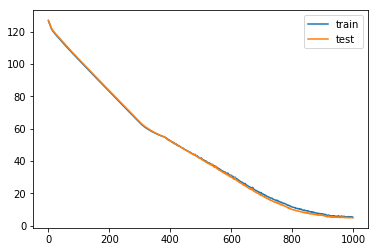

Test RMSE: 7.070


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

sdata = data.copy()
def build_lstm_network(df):
    X_train, X_test, y_train, y_test = ttsplit(df, 0.25)
    
    X_train = X_train.as_matrix().reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.as_matrix().reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(X_train,
                        y_train,
                        epochs=1000,
                        batch_size=20,
                        validation_data=(X_test, y_test),
                        verbose=2,
                        shuffle=False)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    print('Test RMSE: %.3f' % np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    return model

lstm = build_lstm_network(sdata)

In [19]:
def predict_future_stock_values(mdl, source_df, days_out):
    abs_day = LAST_DAY + days_out
    # Warning: Columns must be ordered properly for predictor to work!
    tickers = source_df['ticker'].unique()
    days = np.arange(LAST_DAY + 1, abs_day + 1, 1)

    x = source_df.copy()
    for d in days:        
        # Construct a dataframe for the next day, borrowing appropriate values.
        i = x[x['day'] == x['day'].max()]
        i['day'] += 1
        i['last_day_diff'] = i['close'] - i['last_day_close']
        i['last_day_close'] = i['close']
        i = i.drop(['close'], axis=1)
        
        i = i[['ticker', 'day', 'last_day_close', 'last_day_diff']]
        
        # Predict new close values
        y = mdl.predict(i.as_matrix().reshape((i.shape[0], 1, i.shape[1])))
        i['close'] = pd.Series(y.reshape(y.shape[0]), index=i.index)
        
        x = x.append(i).sort_values(['ticker', 'day'], ascending=[True, True])
        
    x = x[['ticker', 'close', 'day', 'last_day_close', 'last_day_diff']].reset_index(drop=True)
    return x[x['day'] >= LAST_DAY]

future_data = predict_future_stock_values(lstm, sdata, 10)

DAY 365
DAY 366


/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

DAY 367
DAY 368
DAY 369
DAY 370
DAY 371
DAY 372
DAY 373
DAY 374


In [21]:
future_data

,ticker,close,day,last_day_close,last_day_diff
247,0,172.260000,364,169.230000,-1.850000
248,0,161.497757,365,172.260000,3.030000
249,0,161.445343,366,161.497757,-10.762243
250,0,161.441956,367,161.445343,-0.052414
251,0,161.440506,368,161.441956,-0.003387
252,0,161.439117,369,161.440506,-0.001450
253,0,161.437683,370,161.439117,-0.001389
254,0,161.436218,371,161.437683,-0.001434
255,0,161.434723,372,161.436218,-0.001465
256,0,161.433197,373,161.434723,-0.001495


In [28]:
# Term is in number of days from current!
def suggest_strategy(df, principal, target, term, model=None):
    current_day = df['day'].max()
    if not model:
        model = build_lstm_network(df)
    extended_data = predict_future_stock_values(model, df, term)
    
    period = extended_data[(extended_data['day'] >= current_day) & (extended_data['day'] <= current_day + term)]
    stocks_with_current_price = period.groupby('ticker').agg({'close': 'first'})
    candidate_stocks = stocks_with_current_price[stocks_with_current_price['close'] <= 2 * principal].index.values
    candidate_stock_data = period.loc[period['ticker'].isin(candidate_stocks)]
    
    c = []
    for cs in candidate_stocks:
        max_close = candidate_stock_data[candidate_stock_data['ticker'] == cs]['close'].max()
        c.append(max_close)
    
    c = np.array(c)
    A_ub = np.array([np.array(stocks_with_current_price.loc[candidate_stocks]['close']), c])
    b_ub = np.array([principal, target])
    
    optimize_result = linprog(-c, A_ub, b_ub)
    stock_amounts = {codebook[idx]: amnt for 
                         idx, amnt in enumerate(np.round(optimize_result.x, decimals=1)) if amnt > 0}

    return {
        'total': -optimize_result.fun,
        'recommendations': stock_amounts
    }

suggest_strategy(sdata, 200, 222, 100, model=lstm)

DAY 365
DAY 366


/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/miniconda3/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

DAY 367
DAY 368
DAY 369
DAY 370
DAY 371
DAY 372
DAY 373
DAY 374
DAY 375
DAY 376
DAY 377
DAY 378
DAY 379
DAY 380
DAY 381
DAY 382
DAY 383
DAY 384
DAY 385
DAY 386
DAY 387
DAY 388
DAY 389
DAY 390
DAY 391
DAY 392
DAY 393
DAY 394
DAY 395
DAY 396
DAY 397
DAY 398
DAY 399
DAY 400
DAY 401
DAY 402
DAY 403
DAY 404
DAY 405
DAY 406
DAY 407
DAY 408
DAY 409
DAY 410
DAY 411
DAY 412
DAY 413
DAY 414
DAY 415
DAY 416
DAY 417
DAY 418
DAY 419
DAY 420
DAY 421
DAY 422
DAY 423
DAY 424
DAY 425
DAY 426
DAY 427
DAY 428
DAY 429
DAY 430
DAY 431
DAY 432
DAY 433
DAY 434
DAY 435
DAY 436
DAY 437
DAY 438
DAY 439
DAY 440
DAY 441
DAY 442
DAY 443
DAY 444
DAY 445
DAY 446
DAY 447
DAY 448
DAY 449
DAY 450
DAY 451
DAY 452
DAY 453
DAY 454
DAY 455
DAY 456
DAY 457
DAY 458
DAY 459
DAY 460
DAY 461
DAY 462
DAY 463
DAY 464
DAY 465
DAY 466
DAY 467
DAY 468
DAY 469
DAY 470
DAY 471
DAY 472
DAY 473
DAY 474
DAY 475
DAY 476
DAY 477
DAY 478
DAY 479
DAY 480
DAY 481
DAY 482
DAY 483
DAY 484
DAY 485
DAY 486
DAY 487
DAY 488
DAY 489
DAY 490
DAY 491


{'recommendations': {'MSFT': 2.2999999999999998}, 'total': 216.37122668520942}

In [16]:
"""
Improvements:
    - Convert time series to stationary
    - Uniform Scaling for each time series
"""

'\nImprovements:\n    - Convert time series to stationary\n    - Uniform Scaling for each time series\n'